In [1]:
import torch as t
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
import seaborn as sns
from train import train
from models import Transformer, Low_rank
from utils import generate_data, entropy, power_unif_law, generate_each
from interp import back_track, attention_map, by_attention

/Users/leodana/anaconda3/envs/leo_env/lib/python3.11/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
100%|██████████| 5000/5000 [01:26<00:00, 57.93it/s]


0.7710735601186752


100%|██████████| 5000/5000 [01:29<00:00, 55.79it/s]


1.0900574457645416


100%|██████████| 4000/4000 [00:12<00:00, 320.18it/s]


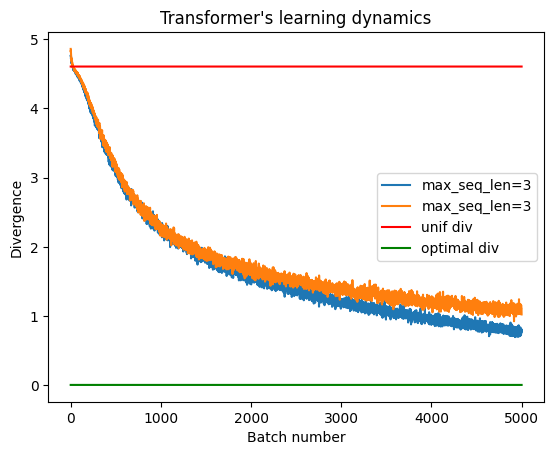

In [5]:
#training transformer

#model params
N = 100
d = 10
nb_layers = 1
width = 0
depth = 1
para = 10
nb_head = 1
n_gram = 3
context_window = n_gram

#distribution params
alphas = [1, 1, 1]
nb_tokens=[40, 40, 1]
t.manual_seed(666)
pi = power_unif_law(alphas, nb_tokens, N)

#learning params
batch_size=2**10
num_batch=5000
lr=1e-3

low_batch_size=2**10
low_num_batch=4000
low_lr=1e-3

device='cpu'
cosim = t.nn.CosineSimilarity(dim=-1)


model = Transformer(d, N, nb_layers, width, depth, para, nb_head, context_window, pi)
Data = generate_data(batch_size=batch_size, num_batch=num_batch, pi=pi, context_window=context_window)
dict = train(model, Data, lr=lr)
plt.plot(dict['Loss'], label=f'max_seq_len={context_window}')
print(sum(dict['Loss'][-100:-1])/100)

model = Transformer(d, N, nb_layers, width, depth, para, nb_head, context_window, pi)
Data = generate_data(batch_size=batch_size, num_batch=num_batch, pi=pi, context_window=context_window)
dict = train(model, Data, lr=lr)
plt.plot(dict['Loss'], label=f'max_seq_len={context_window}')
print(sum(dict['Loss'][-100:-1])/100)

#upper bound
ent=entropy(model.meta_params)
plt.plot([np.log(N)-ent for _ in dict['Loss']], label='unif div', color='red')

#lower bound
model_low = Low_rank(N, d, n_gram, max_seq_len, pi)
Data = generate_data(batch_size=low_batch_size, num_batch=low_num_batch, params=model_low.meta_params)
dict_low = train(model_low, Data, lr=low_lr)
best_loss = sum(dict_low['Loss'][-100:-1])/100
plt.plot([best_loss for _ in dict['Loss']], label='optimal div', color='green')
plt.legend()
plt.xlabel("Batch number")
plt.ylabel("Divergence")
plt.title("Transformer's learning dynamics")
plt.show()

In [ ]:
#Freezing Studies
N = 10
d = 5
nb_layers = 1
width = 0
depth = 1
para = 20
nb_head = 1
n_gram = 3
max_seq_len = n_gram
assert max_seq_len >= n_gram
assert n_gram == 3

#distribution params
alphas = [1, 1, 1]
nb_tokens=[40, 40, 1]
t.manual_seed(666)
pi = power_unif_law(alphas, nb_tokens, N)

#learning params
batch_size=2**10
num_batch=5000
lr=1e-3

Data = generate_data(batch_size=batch_size, num_batch=num_batch, pi=pi, context_window=context_window)

for freeze_E, freeze_QKV, freeze_O, freeze_U in [
    (True, True, False, True), 
    (False, False, True, False),
]:
    freezer = {
        'freeze_E': freeze_E,
        'freeze_QKV': freeze_QKV,
        'freeze_O': freeze_O,
        'freeze_U': freeze_U,
    }
    t.manual_seed(333)
    model = Transformer(d, N, nb_layers, width, depth, para, nb_head, context_window, pi)
    model.freeze(freezer)
    dict = train(model, Data, lr=lr)
    print(freezer)
    print(sum(dict['Loss'][-100:-1])/100)


In [ ]:
#Scaling laws
loss=[]
alpha_1_list=[]
alpha_2_list=[]
N_list=[]
d_list=[]
h_list=[]
nb_layers_list=[]
nb_head_list=[]
para_list=[]
unif_loss=[]
best_loss=[]

context_window = 3
batch_size = 2**9
num_batch = 3000

count = 0
max_count = 99//8
for N in [100]:
    for alpha_1, alpha_2 in product([0.9],[0.6]):
        t.manual_seed(33)
        pi = power_unif_law([alpha_1, alpha_1, alpha_2], N) #to update
        Data = generate_data(batch_size=batch_size, num_batch=num_batch, pi=pi, context_window=context_window)
        ent = entropy(pi).item()
        for d in [10]:
            model_low = Low_rank(N, d, n_gram, context_window, pi)
            dict_low = train(model_low, Data, lr=1e-3)
            best = sum(dict_low['Loss'][-100:-1])/100
            for h in [0]:
                for depth in [1]:
                    for nb_head in [1]:
                        for nb_layers in [1]:
                            for parallel_heads in [i for i in range(1, 100, 8)]:
                                N_list.append(N)
                                d_list.append(d)
                                h_list.append(h)
                                nb_head_list.append(nb_head)
                                nb_layers_list.append(nb_layers)
                                para_list.append(parallel_heads)
                                alpha_1_list.append(alpha_1)
                                alpha_2_list.append(alpha_2)
                                unif_loss.append(-ent+np.log(N))
                                best_loss.append(best)

                                model = Transformer(d, N, nb_layers, width, depth, para, nb_head, context_window, pi)
                                dict = train(model, Data, lr=1e-3)
                                loss.append(sum(dict['Loss'][-100:-1])/100)

                                count+=1
                                print(count/max_count)

dict={
    'alpha_1': alpha_1_list,
    'alpha_2': alpha_2_list,
    'N': N_list,
    'd': d_list,
    'h': h_list,
    'nb_layers': nb_layers_list,
    'nb_head': nb_head_list,
    'para_head': para_list,
    'loss': loss,
    'unif_loss': unif_loss,
    'best_loss': best_loss,
}

data = pd.DataFrame(dict)
data.to_csv('scaling_csv_v3/scaling_mlp_free_3.csv', index=False)

In [5]:
#Architectures Studies

#model params
N = 100
d = 10
h = 0
depth = 1
nb_layers = 1
nb_head = 1
para = 10
n_gram = 3
max_seq_len = n_gram
assert max_seq_len >= n_gram
assert n_gram == 3

#distribution params
alphas = [1, 1, 1]
nb_tokens=[40, 40, 1]
t.manual_seed(666)
pi = power_unif_law(alphas, nb_tokens, N)

#learning params
batch_size=2**10
num_batch=5000
lr=1e-3

device='cpu'
cosim = t.nn.CosineSimilarity(dim=-1)
Data = generate_data(batch_size=batch_size, num_batch=num_batch, pi=pi, context_window=context_window)

for skip_res_connection in [False, True]:
    for skip_pos_QK in [False]:
        for skip_emb_QK in [False]:
            for skip_pos_OV in [False]:
                for skip_emb_OV in [False]:
                    skips = {
                                'skip_res_connection': skip_res_connection,
                                'skip_pos_QK': skip_pos_QK,
                                'skip_emb_QK': skip_emb_QK,
                                'skip_pos_OV': skip_pos_OV,
                                'skip_emb_OV': skip_emb_OV,
                            }
                    t.manual_seed(333)
                    model = Transformer(d, N, nb_layers, width, depth, para, nb_head, context_window, pi)
                    if not((skip_pos_OV and skip_emb_OV) or (skip_pos_QK and skip_emb_QK)):
                        dict = train(model, Data, lr=lr)
                        print(skips)
                        print(sum(dict['Loss'][-100:-1])/100)

/Users/leodana/anaconda3/envs/leo_env/lib/python3.11/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
100%|██████████| 5000/5000 [01:23<00:00, 59.76it/s]


{'skip_res_connection': False, 'skip_pos_QK': False, 'skip_emb_QK': False, 'skip_pos_OV': False, 'skip_emb_OV': False}
0.9117191475629807


100%|██████████| 5000/5000 [01:24<00:00, 59.47it/s]

{'skip_res_connection': True, 'skip_pos_QK': False, 'skip_emb_QK': False, 'skip_pos_OV': False, 'skip_emb_OV': False}
0.8754868823289871


100%|██████████| 5000/5000 [00:42<00:00, 116.72it/s]


6.083942294935696e-05


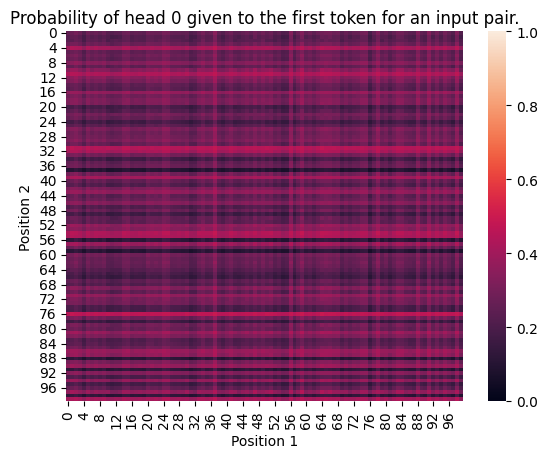

tensor([2.9347e+01, 1.0298e+00, 4.1663e-01, 2.1872e-01, 1.6572e-01, 1.2841e-01,
        1.0561e-01, 4.5328e-02, 3.5894e-02, 1.6583e-02, 1.0574e-02, 7.7494e-03,
        5.3705e-03, 4.2311e-03, 3.1065e-03, 2.7557e-03, 2.1164e-03, 1.4102e-03,
        1.3166e-03, 1.0810e-03, 1.0037e-03, 8.5521e-04, 7.2990e-04, 5.5328e-04,
        5.0677e-04, 4.6557e-04, 4.2783e-04, 3.5600e-04, 3.3412e-04, 3.0005e-04,
        2.8059e-04, 2.6102e-04, 2.3745e-04, 2.1915e-04, 1.8909e-04, 1.7972e-04,
        1.6251e-04, 1.3741e-04, 1.3470e-04, 1.1803e-04, 1.0958e-04, 9.5372e-05,
        9.0607e-05, 8.3150e-05, 7.4362e-05, 5.9416e-05, 5.8945e-05, 5.1891e-05,
        4.7823e-05, 4.1669e-05, 3.3656e-05, 3.1089e-05, 2.8254e-05, 2.4055e-05,
        2.2563e-05, 1.8887e-05, 1.6650e-05, 1.6059e-05, 1.4261e-05, 1.2816e-05,
        1.0929e-05, 9.7006e-06, 9.5728e-06, 8.9417e-06, 7.8957e-06, 7.0544e-06,
        6.7458e-06, 6.0981e-06, 5.2960e-06, 5.0938e-06, 4.5473e-06, 3.9407e-06,
        3.7452e-06, 3.4268e-06, 2.8544e-

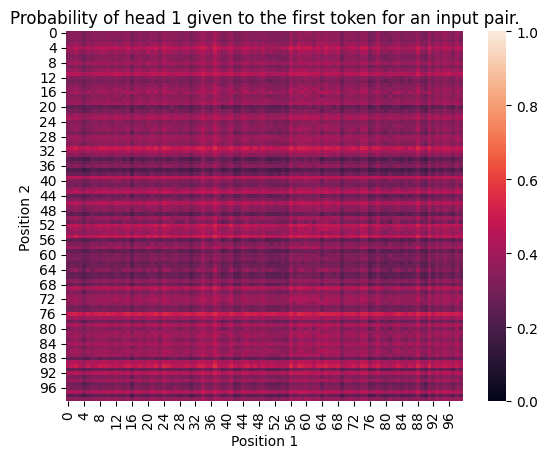

tensor([3.5976e+01, 9.4823e-01, 5.9603e-01, 4.2346e-01, 3.8726e-01, 3.2243e-01,
        1.4051e-01, 6.5225e-02, 3.5259e-02, 1.2624e-02, 1.2434e-02, 1.0083e-02,
        7.9874e-03, 6.2565e-03, 4.9767e-03, 4.4261e-03, 3.6604e-03, 2.5383e-03,
        2.2025e-03, 2.1590e-03, 1.8434e-03, 1.7023e-03, 1.2166e-03, 1.1415e-03,
        1.0259e-03, 9.3501e-04, 7.9297e-04, 6.8810e-04, 6.0142e-04, 5.7093e-04,
        4.8469e-04, 4.3820e-04, 4.0576e-04, 3.2711e-04, 3.1100e-04, 2.7113e-04,
        2.1163e-04, 2.0079e-04, 1.8176e-04, 1.5791e-04, 1.2637e-04, 1.2320e-04,
        1.1511e-04, 1.0878e-04, 1.0561e-04, 9.4214e-05, 8.6666e-05, 7.8380e-05,
        7.6300e-05, 6.9458e-05, 6.6249e-05, 5.9277e-05, 5.5655e-05, 4.8513e-05,
        4.3839e-05, 3.9932e-05, 3.8742e-05, 3.5854e-05, 3.0488e-05, 2.8249e-05,
        2.6510e-05, 2.6042e-05, 2.1777e-05, 2.0692e-05, 1.9295e-05, 1.7298e-05,
        1.6275e-05, 1.5607e-05, 1.1801e-05, 1.1151e-05, 1.0494e-05, 8.6699e-06,
        8.2326e-06, 7.4390e-06, 7.1681e-

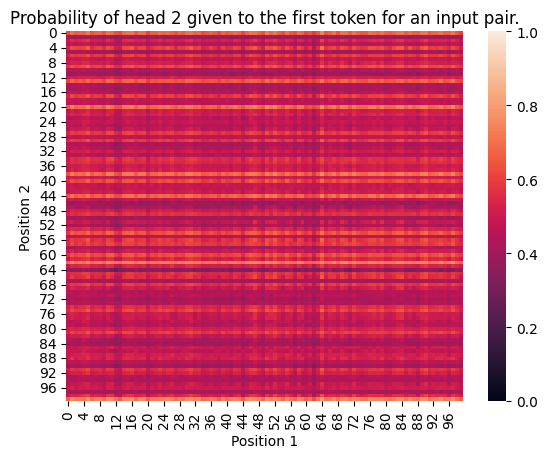

tensor([5.1387e+01, 8.3833e-01, 8.0470e-01, 6.0601e-01, 2.8433e-01, 2.3115e-01,
        1.7634e-01, 6.5490e-02, 4.3408e-02, 1.8071e-02, 1.1417e-02, 9.0042e-03,
        7.4683e-03, 4.4262e-03, 3.2894e-03, 2.5782e-03, 2.4520e-03, 1.7914e-03,
        1.5023e-03, 1.4072e-03, 1.1042e-03, 8.6501e-04, 7.9189e-04, 6.9065e-04,
        5.8483e-04, 5.3534e-04, 5.2647e-04, 5.0113e-04, 4.1607e-04, 3.8599e-04,
        3.5295e-04, 3.0310e-04, 2.8772e-04, 2.5521e-04, 2.2411e-04, 1.9993e-04,
        1.8322e-04, 1.7576e-04, 1.5480e-04, 1.5050e-04, 1.3437e-04, 1.2800e-04,
        1.1366e-04, 1.0875e-04, 9.0419e-05, 8.3434e-05, 8.1084e-05, 7.1853e-05,
        6.2987e-05, 6.2681e-05, 5.7377e-05, 4.7568e-05, 4.3963e-05, 4.2042e-05,
        4.0195e-05, 3.7183e-05, 3.4136e-05, 2.9972e-05, 2.7459e-05, 2.6194e-05,
        2.2973e-05, 2.1842e-05, 1.8245e-05, 1.7178e-05, 1.5115e-05, 1.3787e-05,
        1.3326e-05, 1.2450e-05, 1.1079e-05, 1.0785e-05, 1.0155e-05, 9.3821e-06,
        8.2179e-06, 7.7076e-06, 6.6244e-

In [4]:
#Attention map studies
N = 100
d = 10
nb_layers = 1
width = 0
depth = 1
para = 3
nb_head = 1
n_gram = 3
context_window = n_gram

#learning params
batch_size=2**10
num_batch=5000
lr=1e-3

#distribution params
alphas = [1, 1, 1]
nb_tokens=[10, 10, 1]
t.manual_seed(666)
pi = power_unif_law(alphas, nb_tokens, N)

skips = {
    'skip_res_connection': True,
    'skip_pos_QK': False,
    'skip_emb_QK': False,
    'skip_pos_OV': False,
    'skip_emb_OV': False,
}

model = Transformer(d, N, nb_layers, width, depth, para, nb_head, context_window, pi, skips=skips)
Data = generate_data(batch_size=batch_size, num_batch=num_batch, pi=pi, context_window=context_window)
dict = train(model, Data, lr=lr)
print(sum(dict['Loss'][-100:-1])/100)

for i in range(para):
    map = attention_map(model, 0, i).detach()
    sns.heatmap(map, vmin=0, vmax=1)
    plt.xlabel('Position 1')
    plt.ylabel('Position 2')
    plt.title(f"Probability of head {i} given to the first token for an input pair.")
    plt.show()

    S = t.linalg.svdvals(map)
    print(S)

/Users/leodana/anaconda3/envs/leo_env/lib/python3.11/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
100%|██████████| 5000/5000 [00:22<00:00, 223.86it/s]


0.4165170922875404


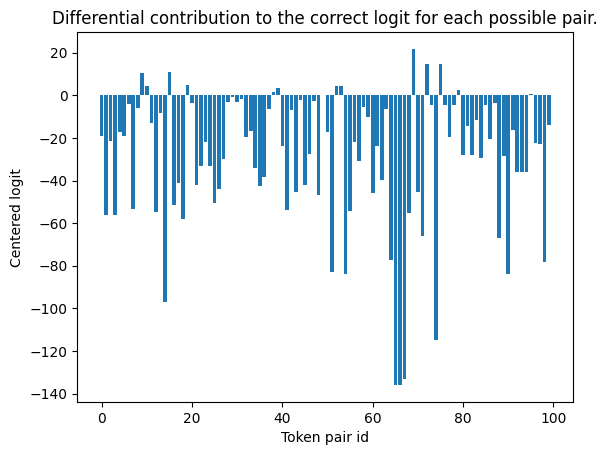

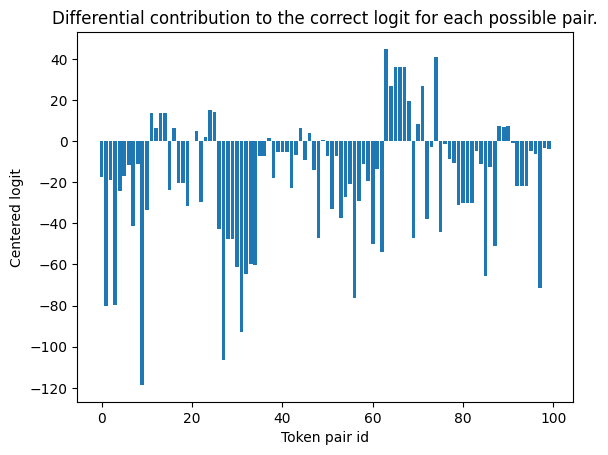

In [2]:
#Per head logit contribution studies
N = 10
d = 5
nb_layers = 1
width = 0
depth = 1
para = 2
nb_head = 1
n_gram = 3
context_window = n_gram

#learning params
batch_size=2**10
num_batch=5000
lr=1e-3

#distribution params
alphas = [1, 1, 1]
nb_tokens=[10, 10, 1]
seed = 2
t.manual_seed(seed)
pi = power_unif_law(alphas, nb_tokens, N)

skips = {
    'skip_res_connection': True,
    'skip_pos_QK': False,
    'skip_emb_QK': False,
    'skip_pos_OV': False,
    'skip_emb_OV': False,
}

t.manual_seed(seed)
model = Transformer(d, N, nb_layers, width, depth, para, nb_head, context_window, pi)
Data = generate_data(batch_size=batch_size, num_batch=num_batch, pi=pi, context_window=context_window)
examples = generate_each(pi)
t.manual_seed(seed)
dict = train(model, Data, lr=lr, seed=seed)
print(sum(dict['Loss'][-100:-1])/100)

contribution = back_track(model, examples)
for i in range(para):
    by_attention(contribution, examples, 0, i, [i], sort=False)

/Users/leodana/anaconda3/envs/leo_env/lib/python3.11/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
100%|██████████| 5000/5000 [00:11<00:00, 453.69it/s]


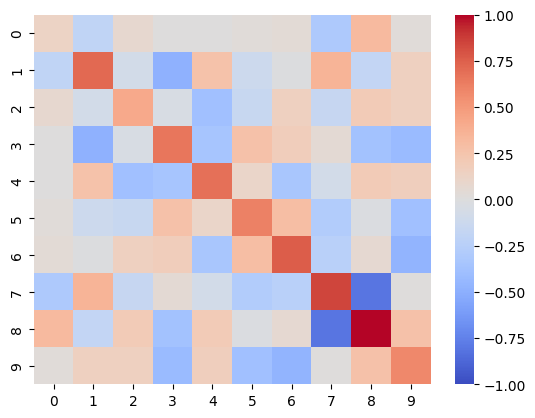

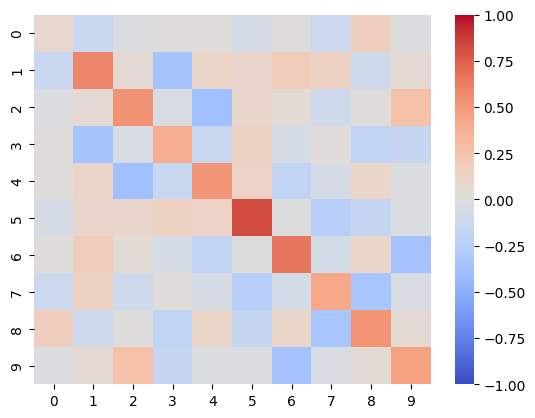

/Users/leodana/anaconda3/envs/leo_env/lib/python3.11/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
100%|██████████| 5000/5000 [00:10<00:00, 456.81it/s]


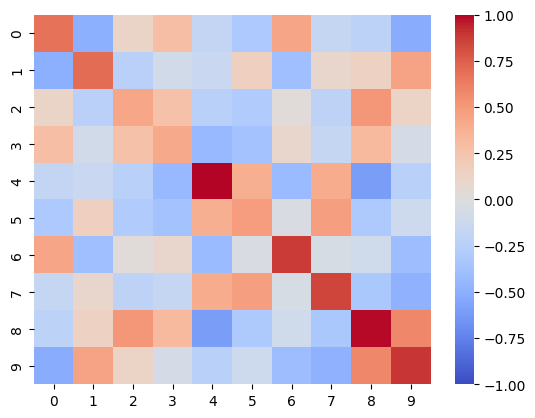

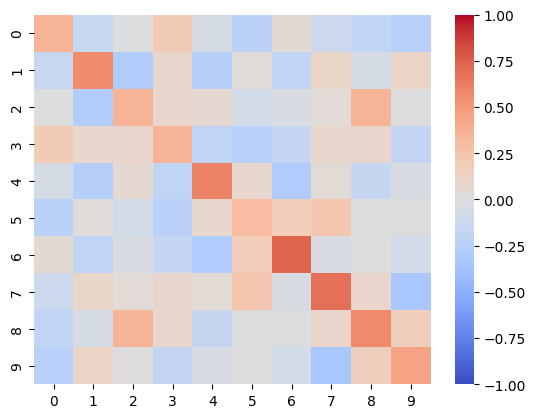

In [22]:
#Superposition
N = 10
d = 5
h = 0
depth = 1
nb_layers = 1
nb_head = 1
para = 1
n_gram = 3
max_seq_len = n_gram
assert max_seq_len >= n_gram
assert n_gram == 3

#distribution params
alphas = [1, 1, 1]
nb_tokens=[10, 1, 1]
t.manual_seed(5)
pi = power_unif_law(alphas, nb_tokens, N)

#learning params
batch_size=2**9
num_batch=5000
lr=1e-3

model = Transformer(d, N, nb_layers, width, depth, para, nb_head, context_window, pi)
Data = generate_data(batch_size=batch_size, num_batch=num_batch, pi=pi, context_window=context_window)
dict = train(model, Data, lr=lr)

W_U = model.unemb.weight.detach()
map = t.einsum('Nd, nd -> Nn', W_U, W_U)
map = map/t.max(map)
sns.heatmap(map, vmin=-1, vmax=1, cmap='coolwarm')
plt.show()

W_U = model.unemb.weight.detach()
map = t.einsum('Nd, ND -> dD', W_U, W_U)
map = t.einsum('Nd, nD, dD -> Nn', W_U, W_U, t.linalg.inv(map))
map = map
sns.heatmap(map, vmin=-1, vmax=1, cmap='coolwarm')
plt.show()

#distribution params
alphas = [1, 1, 0.9]
nb_tokens=[10, 1, 10]
t.manual_seed(444)
pi = power_unif_law(alphas, nb_tokens, N)

model = Transformer(d, N, nb_layers, width, depth, para, nb_head, context_window, pi)
Data = generate_data(batch_size=batch_size, num_batch=num_batch, pi=pi, context_window=context_window)
dict = train(model, Data, lr=lr)

W_U = model.unemb.weight.detach()
map = t.einsum('Nd, nd -> Nn', W_U, W_U)
map = map/t.max(map)
sns.heatmap(map, vmin=-1, vmax=1, cmap='coolwarm')
plt.show()

W_U = model.unemb.weight.detach()
map = t.einsum('Nd, ND -> dD', W_U, W_U)
map = t.einsum('Nd, nD, dD -> Nn', W_U, W_U, t.linalg.inv(map))
map = map
sns.heatmap(map, vmin=-1, vmax=1, cmap='coolwarm')
plt.show()